[View in Colaboratory](https://colab.research.google.com/github/jrmh96/x-ray-classification/blob/master/nihXray.ipynb)

In [1]:
import matplotlib

# import the necessary packages
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


Reproducibility:

In [0]:
test_split = 0.3
R = 125

In [0]:
!pip3 install -U -q PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from nltk.corpus import stopwords

Load in training set: 

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

csv = drive.CreateFile({'id':'1Lc9k3ZSw416x-85reaBGtR4yq9QEkrWl'})

fname = local_download_path + '/'+'sample_label.csv'

print('downloading csv to: {}'.format(fname))

csv.GetContentFile(fname)

print("csv done")
file_list = drive.ListFile(
    {'q': "'1RvsaK1SUdZXL8JL-Z-aD3qevw-1UP5kQ' in parents and trashed=false"}).GetList()
print("Starting pictures download: ")
i=0
for f in file_list:
  # 3. Create & download by id.
  #print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  #print('downloading to {}'.format(fname))
  try:
    if i % 1000 == 0:
      print('downloading picture {} to {}'.format(i, fname))
      print(f)
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)
  #print("done")
    i+=1
  except ApiRequestError:
    print(f)

downloading csv to: /content/data/sample_label.csv
csv done
Starting pictures download: 
downloading picture 0 to /content/data/00002290_000.png
GoogleDriveFile({'kind': 'drive#file', 'id': '14ycihKFo2k8Jss83TIPTpL9u93f_g0aJ', 'etag': '"x-uqYhsK1l_Hqse_91gdlDRJ7wk/MTUyNTgyNDk2NDY0OQ"', 'selfLink': 'https://www.googleapis.com/drive/v2/files/14ycihKFo2k8Jss83TIPTpL9u93f_g0aJ', 'webContentLink': 'https://drive.google.com/uc?id=14ycihKFo2k8Jss83TIPTpL9u93f_g0aJ&export=download', 'alternateLink': 'https://drive.google.com/file/d/14ycihKFo2k8Jss83TIPTpL9u93f_g0aJ/view?usp=drivesdk', 'embedLink': 'https://drive.google.com/file/d/14ycihKFo2k8Jss83TIPTpL9u93f_g0aJ/preview?usp=drivesdk', 'iconLink': 'https://drive-thirdparty.googleusercontent.com/16/type/image/png', 'thumbnailLink': 'https://lh3.googleusercontent.com/3FQc1vNut6rBJZAzMRQN3nSIBJV0wzsYWLCnTnW3A7K3Plf6sovqqE7_PbhmQ6GeAKGoiKeVrh8=s220', 'title': '00002290_000.png', 'mimeType': 'image/png', 'labels': {'starred': False, 'hidden': False

**Image Size: **

In [0]:
HEIGHT=128
WIDTH = 128
CHANNELS = 3
LR = 0.05
EPOCHS = 10
B = 23

In [6]:
LABELPATH = '/content/data/sample_label.csv'

IMAGEPATH = '/content/data'

labels_df = pd.read_csv(LABELPATH)

labels = []

data = []

label = labels_df['Finding Labels']
paths = labels_df['Image Index']
i = 0
j = 0
for p in paths:
  l = label[i]
  pfull = IMAGEPATH+"/"+p
  img = cv2.imread(pfull)
  if i%1000 == 0:
    print('Reading image {} from {}'. format(i+1, pfull))
  if(type(img) == np.ndarray):
  #resize image and add to data set
    img = cv2.resize(img, (HEIGHT, WIDTH))
    data.append(img)
    #split labels and add to label set
    l = l.split("|")
    labels.append(l)
    j+=1
  else:
    print(type(img))
  i+=1

#scale pixel intensities to between 0 and 1
data = np.array(data, dtype="float64")/255.0
labels = np.array(labels)

print('Loaded {} images'.format(j))


Reading image 1 from /content/data/00000013_005.png
Reading image 1001 from /content/data/00005220_005.png
Reading image 2001 from /content/data/00010447_004.png
Reading image 3001 from /content/data/00014764_004.png
Reading image 4001 from /content/data/00019754_002.png
Reading image 5001 from /content/data/00026400_000.png
Loaded 5606 images


In [7]:
print(data.shape)
print(labels.size)

(5606, 128, 128, 3)
5606


In [0]:
# convert labels from strings into binary with scikit
# n-hot encoding
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

In [0]:
VAL_SPLIT = 0.15

(trainX_1, testX, trainY_1, testY) = train_test_split(data, labels, test_size = test_split, random_state = R)

perm = np.random.permutation(len(trainX_1))
v = int(len(trainX_1)*(1-VAL_SPLIT))
indTrain = perm[:v]
indVal = perm[v:]

trainX = trainX_1[indTrain]
trainY = trainY_1[indTrain]

valX = trainX_1[indVal]
valY = trainY_1[indVal]


In [0]:

# define image generator
imagegen = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2,
                        zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

#imagegen.fit(trainX) --> runs out of memory

In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense

In [0]:


def buildModel(height, width, channels, classes):
  model=Sequential()
  inputShape=(height, width, channels)
  
  #First convolution block: 64 filters * 2
  model.add(Conv2D(64, (3,3), padding="same", input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  
  model.add(Conv2D(64, (3,3), padding="same", input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.3))
  
  #Second convolution block: 128 filters
  model.add(Conv2D(128, (3,3), padding="same", input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  
  model.add(Conv2D(128, (3,3), padding="same", input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=-1))
  
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.3))
  
  # Flatten output into fc layers
  
  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  
  model.add(Dense(classes))
  model.add(Activation("softmax"))
  
  return model

In [24]:
model=buildModel(height=HEIGHT, width=WIDTH, channels = 3, classes = len(mlb.classes_))
sgd = SGD(lr = LR)
model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy", "categorical_accuracy"])

print("Beginning Training")

H = model.fit_generator(imagegen.flow(trainX, trainY, batch_size=B), validation_data=(valX, valY), steps_per_epoch=len(trainX)//B, epochs = EPOCHS, verbose=1)


Beginning Training
Epoch 1/10
145/145 [==============================] - 28s 192ms/step - loss: 0.3612 - acc: 0.9092 - categorical_accuracy: 0.1556 - val_loss: 0.2949 - val_acc: 0.9156 - val_categorical_accuracy: 0.2258
Epoch 2/10
145/145 [==============================] - 26s 178ms/step - loss: 0.3171 - acc: 0.9143 - categorical_accuracy: 0.2150 - val_loss: 0.2769 - val_acc: 0.9173 - val_categorical_accuracy: 0.2971
Epoch 3/10
 54/145 [==========>...................] - ETA: 15s - loss: 0.2906 - acc: 0.9204 - categorical_accuracy: 0.2721

145/145 [==============================] - 26s 179ms/step - loss: 0.2917 - acc: 0.9181 - categorical_accuracy: 0.2813 - val_loss: 0.2442 - val_acc: 0.9187 - val_categorical_accuracy: 0.4890
Epoch 4/10
145/145 [==============================] - 26s 179ms/step - loss: 0.2750 - acc: 0.9191 - categorical_accuracy: 0.3190 - val_loss: 0.2551 - val_acc: 0.9187 - val_categorical_accuracy: 0.4363
Epoch 5/10
 86/145 [================>.............] - ETA: 9s - loss: 0.2686 - acc: 0.9200 - categorical_accuracy: 0.3584 

145/145 [==============================] - 26s 179ms/step - loss: 0.2643 - acc: 0.9204 - categorical_accuracy: 0.3604 - val_loss: 0.2481 - val_acc: 0.9190 - val_categorical_accuracy: 0.4822
Epoch 6/10
145/145 [==============================] - 26s 179ms/step - loss: 0.2587 - acc: 0.9200 - categorical_accuracy: 0.3802 - val_loss: 0.2275 - val_acc: 0.9225 - val_categorical_accuracy: 0.5246
Epoch 7/10
 93/145 [==================>...........] - ETA: 8s - loss: 0.2427 - acc: 0.9231 - categorical_accuracy: 0.4296

145/145 [==============================] - 26s 180ms/step - loss: 0.2451 - acc: 0.9219 - categorical_accuracy: 0.4282 - val_loss: 0.2253 - val_acc: 0.9216 - val_categorical_accuracy: 0.5212
Epoch 8/10
145/145 [==============================] - 26s 178ms/step - loss: 0.2452 - acc: 0.9222 - categorical_accuracy: 0.4327 - val_loss: 0.2264 - val_acc: 0.9229 - val_categorical_accuracy: 0.5144
Epoch 9/10
 95/145 [==================>...........] - ETA: 8s - loss: 0.2435 - acc: 0.9220 - categorical_accuracy: 0.4476

145/145 [==============================] - 26s 177ms/step - loss: 0.2422 - acc: 0.9220 - categorical_accuracy: 0.4468 - val_loss: 0.2289 - val_acc: 0.9220 - val_categorical_accuracy: 0.5331
Epoch 10/10
145/145 [==============================] - 26s 180ms/step - loss: 0.2386 - acc: 0.9224 - categorical_accuracy: 0.4633 - val_loss: 0.2280 - val_acc: 0.9202 - val_categorical_accuracy: 0.5195


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
upload = drive.CreateFile({'title': 'sampleUpload.txt'})
upload.SetContentString('Sample Upload File Content')
upload.Upload()

In [0]:
from google.colab import files

In [0]:
#save model to json
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
files.download("model.json")


In [0]:
#save weights to hdf5
model.save("weights.h5")
uploaded = drive.CreateFile({'title': 'weights.h5'})
uploaded.SetContentFile('weights.h5')
uploaded.Upload()

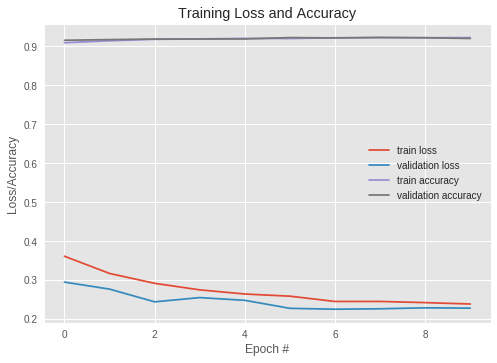

In [40]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,EPOCHS), H.history["loss"], label="train loss")
plt.plot(np.arange(0,EPOCHS), H.history["val_loss"], label="validation loss")
plt.plot(np.arange(0, EPOCHS), H.history["acc"], label="train accuracy")
plt.plot(np.arange(0, EPOCHS), H.history["val_acc"], label="validation accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")

